In [1]:
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
%pylab inline
import os
from __future__ import print_function
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '.')))
if 'ilya' in os.getcwd():
    os.chdir('/Users/ilya/Documents/Kaggle_Bimbo/')
else:
    os.chdir('/Users/margarita/Kaggle/Bimbo/')

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_train = pd.read_csv('train_sample.csv')
print(data_train.shape)
data_train.head()

(1008073, 19)


,Semana,Canal_ID,Ruta_SAK,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,Town,State,NombreProducto,brand,weight,pieces,Has_choco,Has_vanilla,Has_multigrano,NombreCliente,Log_Demanda
0,3,7,3301,4,39.32,0,0.0,4,2008 AG. LAGO FILT,"MEXICO, D.F.",Panquecito Gota Choc 2p 140g BIM 1238,BIM,140.0,2.0,0,0,0,PUESTO DE PERIODICOS LAZARO,1.609438
1,3,7,3301,50,480.00,0,0.0,50,2008 AG. LAGO FILT,"MEXICO, D.F.",Tortillinas 10p 255g TR 1125,TR,255.0,10.0,0,0,0,GUADALAJARA,3.931826
2,3,7,3301,23,458.62,0,0.0,23,2008 AG. LAGO FILT,"MEXICO, D.F.",Pan Blanco 640g BIM 2233,BIM,640.0,NaN,0,0,0,GUADALAJARA,3.178054
3,3,7,3301,14,279.16,0,0.0,14,2008 AG. LAGO FILT,"MEXICO, D.F.",Pan Blanco 640g BIM 2233,BIM,640.0,NaN,0,0,0,SANATORIO ESPANOL SA,2.708050
4,3,7,3301,6,37.50,0,0.0,6,2008 AG. LAGO FILT,"MEXICO, D.F.",Polvoron 6p 113g MLA 31506,MLA,113.0,6.0,0,0,0,PUESTO DEGALLETAS,1.945910


In [3]:
import crossval

cv5fold, strats = crossval.crossvalidation(data_train[['State', 'Semana']])
strats.value_counts()

ESTADO DE MEXICO_3        22574
ESTADO DE MEXICO_4        21901
ESTADO DE MEXICO_5        21168
ESTADO DE MEXICO_8        21040
ESTADO DE MEXICO_9        20849
ESTADO DE MEXICO_7        20170
ESTADO DE MEXICO_6        19979
MEXICO, D.F._3            15738
MEXICO, D.F._4            15612
MEXICO, D.F._9            15527
MEXICO, D.F._8            15480
MEXICO, D.F._7            14489
MEXICO, D.F._6            14176
MEXICO, D.F._5            13564
JALISCO_3                 13447
JALISCO_4                 13148
JALISCO_5                 12935
JALISCO_7                 12580
JALISCO_9                 12286
JALISCO_8                 11954
JALISCO_6                 11848
PUEBLA_7                   8784
PUEBLA_8                   8768
VERACRUZ_3                 8658
PUEBLA_9                   8587
PUEBLA_6                   8565
VERACRUZ_4                 8527
PUEBLA_3                   8403
VERACRUZ_7                 8203
GUANAJUATO_4               8190
                          ...  
TLAXCALA

# Linear Model

In [4]:
data_train['State'].value_counts().shape

(33,)

In [5]:
data_for_model = data_train[['Log_Demanda']].copy()
for c in data_train.columns:
    if data_train[c].dtype.name == 'object': #string
        if data_train[c].value_counts().shape[0] < 34: #states
            data_for_model = pd.concat([data_for_model, pd.get_dummies(data_train[c], dummy_na=False).iloc[:,:-1]]) #without last for non-multicollinearity
        else:
            print(c+': too many values')
    elif c != 'Log_Demanda':
        data_for_model[c] = data_train[c]


Town: too many values
NombreProducto: too many values
brand: too many values
NombreCliente: too many values


In [6]:
data_for_model = data_for_model.fillna(data_for_model.mean())

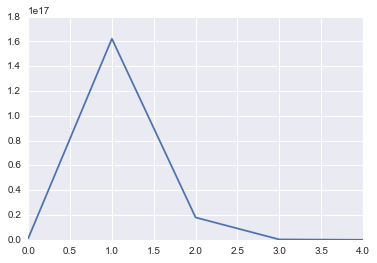

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score

linear = LinearRegression(normalize=True)

scores = cross_val_score(linear, data_for_model.drop('Log_Demanda', axis = 1), 
                         y= data_for_model['Log_Demanda'], 
                         scoring = 'mean_squared_error', cv=cv5fold, n_jobs=-1)

plt.plot(-1*scores)

Переобучился?

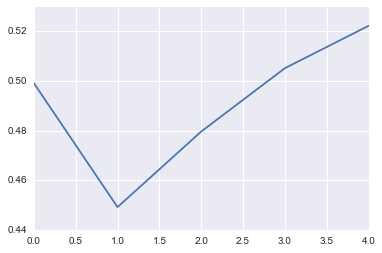

In [8]:
from sklearn.linear_model import ElasticNet

elasticNet = ElasticNet() # L1 + L2 regularization

scores = cross_val_score(elasticNet, data_for_model.drop('Log_Demanda', axis = 1), 
                         y= data_for_model['Log_Demanda'], 
                         scoring = 'mean_squared_error', cv=cv5fold, n_jobs=-1)

plt.plot(-1*scores)

ТОП-20 на лидерборде:)

In [9]:
linear.fit(data_for_model.drop('Log_Demanda', axis = 1), 
                         y= data_for_model['Log_Demanda'])

pd.Series(linear.coef_, index = data_for_model.drop('Log_Demanda', axis = 1).columns)

AGUASCALIENTES           0.001052
BAJA CALIFORNIA NORTE    0.007070
BAJA CALIFORNIA SUR      0.001486
CAMPECHE                 0.008782
CHIAPAS                  0.008769
CHIHUAHUA                0.007020
COAHUILA                 0.002174
COLIMA                   0.010651
Canal_ID                 0.054900
DURANGO                  0.003138
Demanda_uni_equil        0.014822
Dev_proxima             -0.000205
Dev_uni_proxima         -0.023882
ESTADO DE MEXICO         0.009868
GUANAJUATO               0.003017
GUERRERO                -0.000043
HIDALGO                  0.002875
JALISCO                  0.006961
MEXICO, D.F.             0.012887
MICHOACAN                0.002555
MORELOS                  0.006053
NAYARIT                  0.006748
NUEVO LEON               0.006157
OAXACA                  -0.002527
PUEBLA                  -0.001416
QUERETARO                0.007930
QUINTANA ROO             0.011190
Queretaro de Arteaga     0.001377
Ruta_SAK                 0.000028
SAN LUIS POTOS